In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import natsort

In [6]:
from matplotlib.image import imread
import matplotlib.pyplot as plt

In [7]:
data_path = 'drive/MyDrive/Sential_2_tif_EuroSAT_RGB/'

In [8]:
os.listdir(data_path)

['AnnualCrop',
 'HerbaceousVegetation',
 'SeaLake',
 'River',
 'Forest',
 'Residential',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Highway']

1. klastrowanie na jednym zdjęciu rgb

#Mini Batch K-means clastering (pixel by pixel)

In [9]:
from sklearn.cluster import MiniBatchKMeans

In [13]:
epochs = 10
n_clusters = 20

In [14]:
kmeans = MiniBatchKMeans(n_clusters=n_clusters,
                         random_state=42,
                         batch_size=4096)

one batch = one image

In [15]:
for i in range(epochs):
    for folder_name in os.listdir(data_path):
        for image_name in os.listdir(os.path.join(data_path, folder_name)):
            image = imread(os.path.join(data_path, folder_name, image_name))
            X = image.reshape(-1, 3)/255
            kmeans = kmeans.partial_fit(X)

# Receaving the 100 image representants 

In [16]:
def cluster_px_rep2px_sum_each_cluster(img_prediction, k=n_clusters):
    out = [0]*k
    for px_pred in img_prediction:
       out[px_pred] -= 1
    return out 

In [17]:
img_represen_arr = np.array(['AnnualCrop_1.jpg']*n_clusters)
img_represen_best_scores = np.array([np.inf]*n_clusters)
for i in range(10):
    for folder_name in os.listdir(data_path):
        for image_name in os.listdir(os.path.join(data_path, folder_name)):
            image = imread(os.path.join(data_path, folder_name, image_name))
            X = image.reshape(-1, 3)/255
            X_cluster_eukl_dist_from_centers = kmeans.predict(X)
            tmp_dist_arr = np.array(cluster_px_rep2px_sum_each_cluster(X_cluster_eukl_dist_from_centers))
            tmp_img_arr = np.array([image_name]*n_clusters)
            img_represen_arr = np.where(img_represen_best_scores<=tmp_dist_arr, img_represen_arr, tmp_img_arr)
            img_represen_best_scores = np.minimum(img_represen_best_scores, tmp_dist_arr)

In [18]:
img_represen_arr

array(['AnnualCrop_95.jpg', 'SeaLake_63.jpg', 'AnnualCrop_21.jpg',
       'AnnualCrop_44.jpg', 'SeaLake_20.jpg', 'SeaLake_75.jpg',
       'AnnualCrop_85.jpg', 'AnnualCrop_15.jpg', 'AnnualCrop_92.jpg',
       'Highway_59.jpg', 'AnnualCrop_16.jpg',
       'HerbaceousVegetation_98.jpg', 'SeaLake_52.jpg',
       'Residential_86.jpg', 'SeaLake_98.jpg', 'AnnualCrop_93.jpg',
       'River_64.jpg', 'SeaLake_68.jpg', 'Residential_80.jpg',
       'AnnualCrop_20.jpg'], dtype='<U28')

I only do this because I know the labels of these photos, normally I would have labeled it by hand:

In [19]:
labels = img_represen_arr.copy()
for i, name in enumerate(img_represen_arr):
    labels[i] = name.split(sep='_', maxsplit=1)[0]

In [20]:
kmeans.cluster_centers_

array([[0.67857478, 0.49945444, 0.4617459 ],
       [0.35192016, 0.37216433, 0.3955227 ],
       [0.49414708, 0.41559085, 0.41650863],
       [0.77390067, 0.58403782, 0.53558182],
       [0.4116992 , 0.45927106, 0.50669715],
       [0.15275338, 0.2506447 , 0.30369546],
       [0.5646643 , 0.45769709, 0.44465724],
       [0.62528432, 0.52495605, 0.50734146],
       [0.60515656, 0.57556893, 0.58756737],
       [0.52682834, 0.52366421, 0.55359641],
       [0.57680274, 0.49966563, 0.4890188 ],
       [0.47730432, 0.453868  , 0.45653837],
       [0.4130902 , 0.41416609, 0.43436457],
       [0.94841183, 0.84715434, 0.8068988 ],
       [0.25004114, 0.3311433 , 0.35874135],
       [0.86136201, 0.6864855 , 0.6313844 ],
       [0.50531406, 0.4842074 , 0.49673659],
       [0.30177763, 0.4016279 , 0.47743017],
       [0.70512664, 0.64650847, 0.64540718],
       [0.6829561 , 0.56567924, 0.53645792]])

In [21]:
X_rep = kmeans.cluster_centers_

In [22]:
X_rep.shape

(20, 3)

# Training linear reggresion only on the labeled centras with their neighbours

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_rep, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Checking how it looks like on the testing data




In [29]:
import random

In [32]:
image_name = random.choice(os.listdir('drive/MyDrive/test'))

'Forest_512.jpg'

In [33]:
image = imread(os.path.join('drive/MyDrive/test', image_name))
im_out = log_reg.predict(image.reshape(-1, 3)/255)
im_out = im_out.reshape(image.shape[:-1])

In [46]:
real_label = image_name.split(sep='_', maxsplit=1)[0] 

Text(0.5, 1.0, 'Forest')

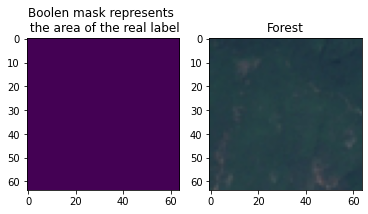

In [49]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(im_out == real_label)
axs[0].set_title('Boolen mask represents \n the area of the real label')

axs[1].imshow(image)
axs[1].set_title(real_label)